## Regularization: Bias vs Variance

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.optimize #fmin_cg to train the linear regression
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
datafile = '/Users/wiseer85/Documents/Data Science/ML Exercises/data/ex5data1.mat'
mat = scipy.io.loadmat( datafile )

# Training set
X, y = mat['X'], mat['y']

# Cross validation set
Xval, yval = mat['Xval'], mat['yval']

# Test set
Xtest, ytest = mat['Xtest'], mat['ytest']

#Insert a column of 1's to all of the X's, as usual
X =     np.insert(X    ,0,1,axis=1)
Xval =  np.insert(Xval ,0,1,axis=1)
Xtest = np.insert(Xtest,0,1,axis=1)

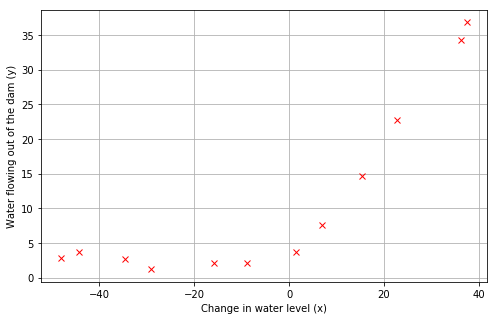

In [3]:
# Plot data
def plotData():
    plt.figure(figsize=(8,5))
    plt.ylabel('Water flowing out of the dam (y)')
    plt.xlabel('Change in water level (x)')
    plt.plot(X[:,1],y,'rx')
    plt.grid(True)
    
plotData()

In [4]:
# Define cost function
def h(theta,X): #Linear hypothesis function
    return np.dot(X,theta)

def computeCost(mytheta,myX,myy,mylambda=0.): #Cost function
    m = myX.shape[0]
    myh = h(mytheta,myX).reshape((m,1))
    mycost = float((1./(2*m)) * np.dot((myh-myy).T,(myh-myy)))
    regterm = (float(mylambda)/(2*m)) * float(mytheta[1:].T.dot(mytheta[1:]))
    return mycost + regterm

# Calculate cost
mytheta = np.array([[1.],[1.]])
print(computeCost(mytheta,X,y,mylambda=1.))

303.9931922202643


In [5]:
# Regularized linear regression gradient
def computeGradient(mytheta,myX,myy,mylambda=0.):
    mytheta = mytheta.reshape((mytheta.shape[0],1))
    m = myX.shape[0]
    #grad has same shape as myTheta (2x1)
    myh = h(mytheta,myX).reshape((m,1))
    grad = (1./float(m))*myX.T.dot(h(mytheta,myX)-myy)
    regterm = (float(mylambda)/m)*mytheta
    regterm[0] = 0 #don't regulate bias term
    regterm.reshape((grad.shape[0],1))
    return grad + regterm

# wrapper for computeGradient that flattens the output for minimization
def computeGradientFlattened(mytheta,myX,myy,mylambda=0.):
    return computeGradient(mytheta,myX,myy,mylambda=0.).flatten()

# Calculate gradient
mytheta = np.array([[1.],[1.]])
print(computeGradient(mytheta,X,y,1.))


[[ -15.30301567]
 [ 598.25074417]]


Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 28


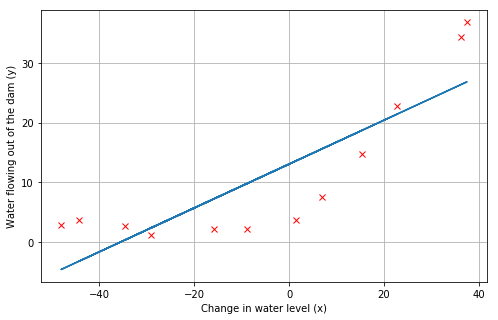

In [6]:
# Fitting linear regression
def optimizeTheta(myTheta_initial, myX, myy, mylambda=0.,print_output=True):
    fit_theta = scipy.optimize.fmin_cg(computeCost,x0=myTheta_initial,                                       fprime=computeGradientFlattened,                                       args=(myX,myy,mylambda),                                       disp=print_output,                                       epsilon=1.49e-12,                                       maxiter=1000)
    fit_theta = fit_theta.reshape((myTheta_initial.shape[0],1))
    return fit_theta

mytheta = np.array([[1.],[1.]])
fit_theta = optimizeTheta(mytheta,X,y,0.)

plotData()
plt.plot(X[:,1],h(fit_theta,X).flatten())

In [7]:
# Define learning curve
def plotLearningCurve():
    initial_theta = np.array([[1.],[1.]])
    mym, error_train, error_val = [], [], []
    for x in range(1,13,1):
        train_subset = X[:x,:]
        y_subset = y[:x]
        mym.append(y_subset.shape[0])
        fit_theta = optimizeTheta(initial_theta,train_subset,y_subset,mylambda=0.,print_output=False)
        error_train.append(computeCost(fit_theta,train_subset,y_subset,mylambda=0.))
        error_val.append(computeCost(fit_theta,Xval,yval,mylambda=0.))
        
    plt.figure(figsize=(8,5))
    plt.plot(mym,error_train,label='Train')
    plt.plot(mym,error_val,label='Cross Validation')
    plt.legend()
    plt.title('Learning curve for linear regression')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.grid(True)

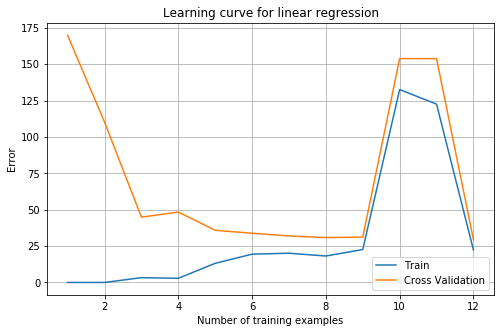

In [8]:
# Plot train error and cross validation error
plotLearningCurve()

Both the train error and cross validation error are high when the number of training examples is increased. This reflects a high bias problem in the model, whereby the linear regression model is too simple to fit the data.

In [9]:
# Define functions
# Polynomial regression
def genPolyFeatures(myX,p):
    newX = myX.copy()
    for i in range(p):
        dim = i+2
        newX = np.insert(newX,newX.shape[1],np.power(newX[:,1],dim),axis=1)
    return newX

# Normalization
def featureNormalize(myX):
    Xnorm = myX.copy()
    stored_feature_means = np.mean(Xnorm,axis=0) #column-by-column
    Xnorm[:,1:] = Xnorm[:,1:] - stored_feature_means[1:]
    stored_feature_stds = np.std(Xnorm,axis=0,ddof=1)
    Xnorm[:,1:] = Xnorm[:,1:] / stored_feature_stds[1:]
    return Xnorm, stored_feature_means, stored_feature_stds

Optimization terminated successfully.
         Current function value: 0.198053
         Iterations: 179
         Function evaluations: 352
         Gradient evaluations: 352


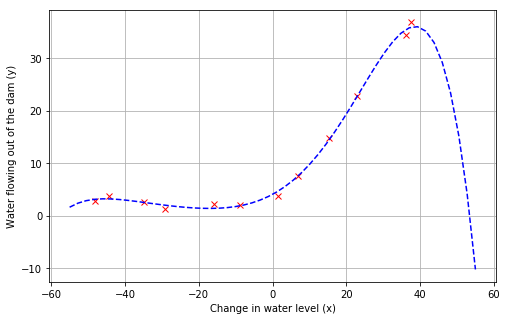

In [10]:
# Generate an X matrix 
global_d = 5
newX = genPolyFeatures(X,global_d)
newX_norm, stored_means, stored_stds = featureNormalize(newX)

# Fit parameters starting with 1's as the initial guess
mytheta = np.ones((newX_norm.shape[1],1))
fit_theta = optimizeTheta(mytheta,newX_norm,y,0.)

def plotFit(fit_theta,means,stds):
    n_points_to_plot = 50
    xvals = np.linspace(-55,55,n_points_to_plot)
    xmat = np.ones((n_points_to_plot,1))
    
    xmat = np.insert(xmat,xmat.shape[1],xvals.T,axis=1)
    xmat = genPolyFeatures(xmat,len(fit_theta)-2)
    #This is undoing feature normalization
    xmat[:,1:] = xmat[:,1:] - means[1:]
    xmat[:,1:] = xmat[:,1:] / stds[1:]
    plotData()
    plt.plot(xvals,h(fit_theta,xmat),'b--')

# Plot fit
plotFit(fit_theta,stored_means,stored_stds)

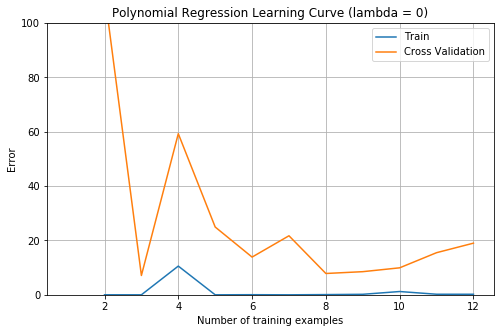

In [11]:
# Plot learning curve
def plotPolyLearningCurve(mylambda=0.):

    initial_theta = np.ones((global_d+2,1))
    mym, error_train, error_val = [], [], []
    myXval, dummy1, dummy2 = featureNormalize(genPolyFeatures(Xval,global_d))

    for x in range(1,13,1):
        train_subset = X[:x,:]
        y_subset = y[:x]
        mym.append(y_subset.shape[0])
        train_subset = genPolyFeatures(train_subset,global_d)   
        train_subset, dummy1, dummy2 = featureNormalize(train_subset)
        fit_theta = optimizeTheta(initial_theta,train_subset,y_subset,mylambda=mylambda,print_output=False)
        error_train.append(computeCost(fit_theta,train_subset,y_subset,mylambda=mylambda))
        error_val.append(computeCost(fit_theta,myXval,yval,mylambda=mylambda))
        
    plt.figure(figsize=(8,5))
    plt.plot(mym,error_train,label='Train')
    plt.plot(mym,error_val,label='Cross Validation')
    plt.legend()
    plt.title('Polynomial Regression Learning Curve (lambda = 0)')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.ylim([0,100])
    plt.grid(True)
    
plotPolyLearningCurve()

         Current function value: 7.797052
         Iterations: 9
         Function evaluations: 238
         Gradient evaluations: 225


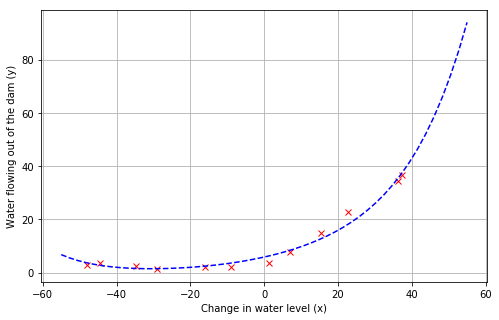

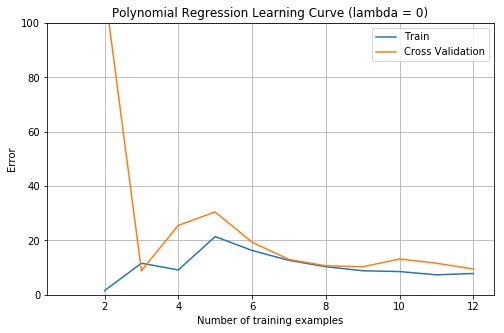

In [12]:
# Try Lambda = 1
mytheta = np.zeros((newX_norm.shape[1],1))
fit_theta = optimizeTheta(mytheta,newX_norm,y,1)
plotFit(fit_theta,stored_means,stored_stds)
plotPolyLearningCurve(1.)

         Current function value: 126.400648
         Iterations: 1
         Function evaluations: 65
         Gradient evaluations: 53


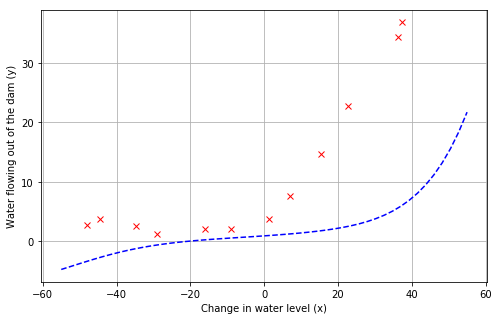

In [13]:
# Lambda = 100
mytheta = np.random.rand(newX_norm.shape[1],1)
fit_theta = optimizeTheta(mytheta,newX_norm,y,100.)
plotFit(fit_theta,stored_means,stored_stds)

After one iteration, a lambda of 100 penalizes the theta parameters and thus losing precision.
The plot  is NOT indicative of a successful fit.

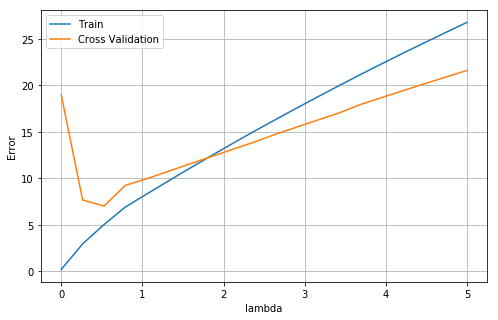

In [14]:
# Selecting lambda using a cross validation set
# lambdas = [0., 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1., 3., 10.]
lambdas = np.linspace(0,5,20)
errors_train, errors_val = [], []
for mylambda in lambdas:
    newXtrain = genPolyFeatures(X,global_d)
    newXtrain_norm, dummy1, dummy2 = featureNormalize(newXtrain)
    newXval = genPolyFeatures(Xval,global_d)
    newXval_norm, dummy1, dummy2 = featureNormalize(newXval)
    init_theta = np.ones((newX_norm.shape[1],1))
    fit_theta = optimizeTheta(mytheta,newXtrain_norm,y,mylambda,False)
    errors_train.append(computeCost(fit_theta,newXtrain_norm,y,mylambda=mylambda))
    errors_val.append(computeCost(fit_theta,newXval_norm,yval,mylambda=mylambda))

plt.figure(figsize=(8,5))
plt.plot(lambdas,errors_train,label='Train')
plt.plot(lambdas,errors_val,label='Cross Validation')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('Error')
plt.grid(True)